## Analyzing Hacker News data

To run this analysis, A web scrapper was built that crawled the official [Hacker News API](https://github.com/HackerNews/API), and obtained a list of posts during the months of July - Oct 2022. Posts including comments,stories and jobs were scrapped and user information and karma points were also included in the dataset.

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")

In [2]:
# reading in the datasets
hn_posts = pd.read_csv("data/hn_posts.csv",
          names=['id','type','parent','text','kids','comment_counts','score','title','posted_by','created_at']
           )
hn_users = pd.read_csv("data/hn_users.csv",names=['name','karma','created_at'])

In [4]:
hn_posts.sample(5)

,id,type,parent,text,kids,comment_counts,score,title,posted_by,created_at
581655,32816476,comment,32816405.0,I didn&#x27;t realize this was a thing till I ...,"{32824586,32824624}",NaN,NaN,NaN,vlod,1663014677
339358,33058746,comment,33058450.0,&gt; He&#x27;s right. Not just for Common Lisp...,{33060426},NaN,NaN,NaN,Test0129,1664735236
680379,32717691,comment,32717613.0,I would suggest you make yourself knowledgeabl...,{32721029},NaN,NaN,NaN,desindol,1662325311
142679,33255377,comment,33252093.0,&gt; The fact that neural networks have been t...,{33255598},NaN,NaN,NaN,ketralnis,1666134962
357835,33040255,comment,33036665.0,"Manhattan should end street parking, paid or f...",NaN,NaN,NaN,NaN,addicted,1664569300


In [6]:
print(f"Shape of posts {hn_posts.shape}")
print(f"Shape of users table {hn_users.shape}")

Shape of posts (1127716, 10)
Shape of users table (77882, 3)


In [268]:
# checking the type of posts we have
hn_posts['type'].value_counts()

comment    1030581
story        96753
job            231
pollopt        126
poll            25
Name: type, dtype: int64

We have more than a million comments and 90k+ stories in the dataset.

### Cleaning the dataset
Now we clean our dataset and remove `null` values in columns where we are dont expect them, we also convert `timestamp` into `date time` object for easy analysis.

In [8]:
# checking number of missing values in each column
hn_posts.isna().sum()

id                      0
type                    0
parent              97135
text               140090
kids               620919
comment_counts    1052406
score             1033395
title             1052176
posted_by           31101
created_at              0
dtype: int64

In [9]:
## dropping all posts where posted_by is null, we expect posted_by to not contain null values
hn_posts = hn_posts[hn_posts['posted_by'] != None];

In [217]:
#converting the created_at column into datetime 
dict_map = {0: 'Sun', 1: 'Mon',2:"Tue",3:'Wed',4:'Thur',5:'Fri',6:'Sat'}

hn_posts['created_at'] = pd.to_datetime(hn_posts['created_at'],unit='s') 
hn_posts['date'] = hn_posts['created_at'].dt.date
hn_posts['day_of_week'] = hn_posts['created_at'].dt.day_of_week.map(dict_map)
hn_posts['hour'] = hn_posts['created_at'].dt.hour

## Exploratory Analysis
In this section, we perform exploratory analysis and try to answer questions such as:
- What time and day of the week receives the highest engagement.
- What people on Hackernews talk about: Entity Recognition

<AxesSubplot:xlabel='day_of_week', ylabel='score'>

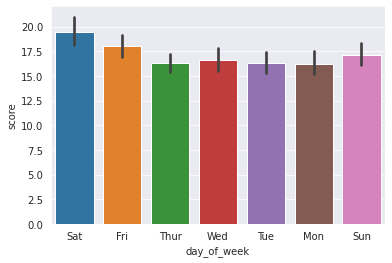

In [259]:
# day of week were posts have the highest scores
sns.barplot(data=hn_posts,x='day_of_week',y='score')

Saturday seems the day were posts seems to score the highest

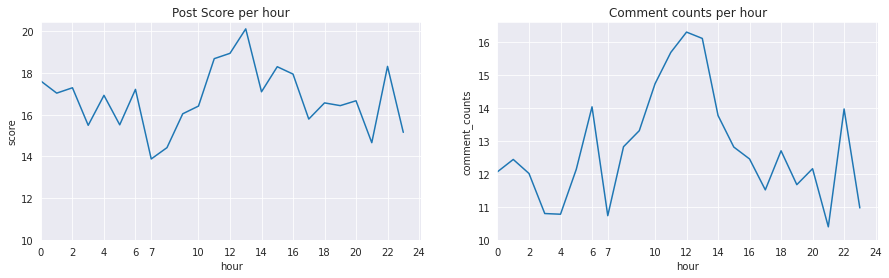

In [263]:
fig,axes = plt.subplots(1,2,sharex=True)
fig.set_figwidth(15)
sns.lineplot(data=hn_posts,x='hour',y='score',ci=None,ax=axes[0])
sns.lineplot(data=hn_posts,x='hour',y='comment_counts',ci=None,ax=axes[1])
for ax in axes:
    ax.set_ylim(ymin=10)
    ax.set_xlim(xmin=0)
axes[0].set_title('Post Score per hour')
axes[1].set_title("Comment counts per hour")
plt.xticks([0,2,4,6,7,10,12,14,16,18,20,22,24]);

The best time to post a story seems to be between *12pm - 1pm* GMT +1, this period as might be expected seems also has more interaction by comment counts.